# Dataset

This notebook is used as a first veiw on the dataset for understanding how the data can be used

## Make clean csv

We add multiple csv files for each language (train, test, dev). But there are useless information. Like the age the gender and the line said. Moreover, their is no columns for the language. So we had to créate our csv with all the needed information (id, path to the audio file, language). Here the langugage columns is our labels.

In [1]:
import polars as pl
import numpy as np
import os

In [2]:
dataset_path = "../data/common_voice_kpd/"
languages = os.listdir("../data/common_voice_kpd/")
dataset_path, languages[14]

('../data/common_voice_kpd/', 'Italian')

In [ ]:
with open("../data/common_voice_kpd/French/train.csv", "r", encoding="utf-16") as f:
    lines = f.readline()
    lines = lines.split()
    client_id = np.array([])
    path = np.array([])
    language = np.array([])
    while True:
        lines = f.readline()
        if not lines:
            break
        lines = lines.split()
        client_id = np.append(client_id, np.int16(lines[0]))
        path = np.append(path, f"/train/{lines[1]}/{lines[2]}")
        language = np.append(language, "French")

    df = (
        pl.DataFrame({
            "client_id": client_id,
            "path":path,
            "language": language,
        })
    )

df
        

client_id,path,language
f64,str,str
98.0,"""/train/frn_trn_sp_98/common_vo…","""French"""
539.0,"""/train/frn_trn_sp_426/common_v…","""French"""
109.0,"""/train/frn_trn_sp_109/common_v…","""French"""
1068.0,"""/train/frn_trn_sp_691/common_v…","""French"""
1036.0,"""/train/frn_trn_sp_675/common_v…","""French"""
…,…,…
150.0,"""/train/frn_trn_sp_150/common_v…","""French"""
351.0,"""/train/frn_trn_sp_331/common_v…","""French"""
24.0,"""/train/frn_trn_sp_24/common_vo…","""French"""


In [70]:
file_type = ["train","test","dev"]
for lang in languages:
    for file in file_type:
        with open(f"../data/common_voice_kpd/{lang}/{file}.csv", "r", encoding="utf-16") as f:
            lines = f.readline()
            client_id = np.array([], dtype=np.int16)
            path = np.array([])
            language = np.array([])
            while True:
                lines = f.readline()
                if not lines:
                    break
                lines = lines.split()
                client_id = np.append(client_id, np.int16(lines[0]))
                path = np.append(path, f"/{lang}/{file}/{lines[1]}/{lines[2]}")
                language = np.append(language, lang)

            df = (
                pl.DataFrame({
                    "client_id": client_id,
                    "path":path,
                    "language": language,
                })
            )

        df.write_csv(f"../data/common_voice_kpd/{lang}/{file}_clean.csv")

In [7]:
file_type = ["train_clean","test_clean","dev_clean"]
for file in file_type:
    combined_df = pl.DataFrame({
        "client_id": np.array([]),
        "path": np.array([]),
        "language": np.array([]),
    }).with_columns(
        pl.col("*").cast(pl.String)
    )
    for lang in languages:
        df = pl.read_csv(
            f"../data/common_voice_kpd/{lang}/{file}.csv"
            ).with_columns(
                pl.col("*").cast(pl.String)
            )
        combined_df = pl.concat([combined_df, df])
    combined_df.write_csv(f"../data/{file}.csv")

In [3]:
dfTrain = pl.read_csv("../data/train_clean.csv").sample(fraction=1.0, shuffle=True)
dfTrain.head()

client_id,path,language
i64,str,str
1619,"""/Indonesian/train/indo_trn_sp_…","""Indonesian"""
162,"""/French/train/frn_trn_sp_162/c…","""French"""
60,"""/Swedish/train/swd_trn_sp_25/c…","""Swedish"""
1583,"""/Czech/train/czh_trn_sp_187/co…","""Czech"""
727,"""/Czech/train/czh_trn_sp_146/co…","""Czech"""


## Load wav files

In order to create the model we had to read the data (WAV)

In [3]:
import torchaudio as ta

waveform, sample_rate = ta.load("../data/common_voice_kpd/Swedish/train/swd_trn_sp_80/common_voice_sv-SE_19518866.wav")
waveform, sample_rate

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1035e-05, 0.0000e+00,
          6.1035e-05]]),
 16000)

In [4]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt


2.9.1+cu128
2.9.1+cu128


In [5]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import _download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = _download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    power_to_db = T.AmplitudeToDB("power", 80.0)
    ax.imshow(power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [6]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

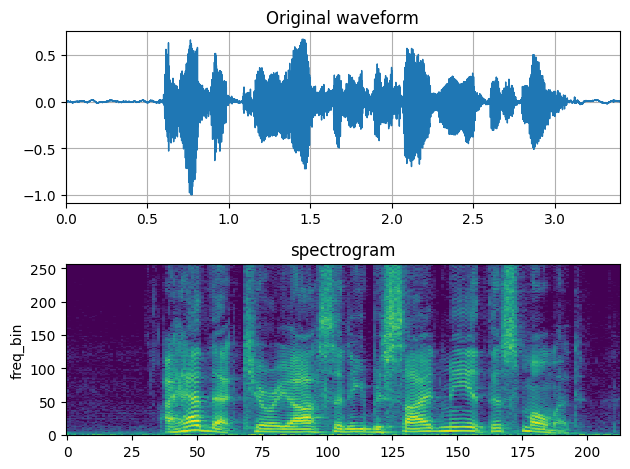

In [7]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()